# Solar System Simulator

*   **Author:** Jonathan Hanna
*   **Date:** 12/17/2024


## Overview

This is a working simulation of our solar system in real time. I've created two animations: one containing the terrestrial planets with trajectory lines and another containing all 8 planets without trajectory lines (for reasons explained later).

To find the initial conditions of the trajectories of our planets, I used the [astroquery](https://astroquery.readthedocs.io/en/latest/jplhorizons/jplhorizons.html) package to search for the data from the [JPL Horizons On-Line Ephemeris System](https://ssd.jpl.nasa.gov/horizons/) on the position and trajectory of the celestial bodies.

After grabbing the initial conditions, the simulation itself is just a simple 2-dimensional first-order (Euler) integrator.

In [ ]:
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.8/994.8 kB 37.2 MB/s eta 0:00:00


In [ ]:
from astroquery.jplhorizons import Horizons
from astropy.time import Time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

## Using JPL Horizons

* **Time:** There's a YYYY-MM-DD string that represents the initial time of the simulation that we will use to get the initial conditions of the planets. This is done for readability purposes--the actual time used in Horizons is in Julian Date format, which we calculate by converting the YYYY-MM-DD string using `astropy.time`. For this demo, we begin in January 1, 1960 (1960-01-01), the earliest UTC time.

* **State Vector:** To get the position and velocity of the celestial body at its given epoch, also known as the state vector, we initialize the `Horizons` object (with the ID of the planet, the chosen origin of our coordinate system, and the start time calculated earlier) and simply call `vectors()` on it. To demonstrate the metadata given in the state vector, we print out its columns.

  Here, 'x/y/z' (AU) and 'vx/vy/vz' (AU/day) are the positions and velocities. This is the only information we need to begin.

In [ ]:
start_time_yyyy_mm_dd = "1960-01-01"
start_time_jd = Time(start_time_yyyy_mm_dd).jd

earth_data = Horizons(id='399', location='@sun', epochs=start_time_jd).vectors()
print(earth_data.columns)

<TableColumns names=('targetname','datetime_jd','datetime_str','x','y','z','vx','vy','vz','lighttime','range','range_rate')>


## A note on acceleration and relevant constants:

This is the gravitational acceleration applied to the position vector of a planet

$$\vec{a_r} = - \frac{GM_\odot \vec{r}}{(||\vec{r}||^2)^{3/2}}$$

Because the state vector's position and time is measured in AU and days, we must rewrite $G$ as such:

$$G = 6.673 \times 10^{-11} \frac{m^3}{kg s^2} \times (\frac{1 AU}{1.4960\times10^{11} m})^3 \times (\frac{86400 s}{1 d})^2$$

$$G = 1.487831774 \times 10^{-34} \frac{AU^3}{kg d^2}$$

Noting that $M_\odot = 1.989 \times 10^{30} kg$, we can then define a constant

$$GM = GM_\odot = 1.487831774 \times 10^{-34} \frac{AU^3}{kg d^2} \times 1.989 \times 10^{30} kg$$

$$ GM = 2.95929739849 \times 10^{-4} \frac{AU^3}{d^2}$$

Which is what we use in our step function.

## Simulation

Here, we define the constant $GM$ and the functions used to simulate the orbit of one planet

In [ ]:
# constants
GM = 2.95929739849e-4 # AU^3 / day^2

def a(planet):
  return (-GM * planet['r'] / (np.sum(planet['r']**2))**(3.0/2))

def StepPlanet(planet, positions, trails, trail, dt):
  # handle positions
  planet['v'] += a(planet) * dt
  planet['r'] += planet['v'] * dt
  planet['point'].set_offsets(planet['r'][:2])
  positions.append(planet['point'])

  # handle trails
  planet['xs'].append(planet['r'][0])
  planet['ys'].append(planet['r'][1])
  trail.set_xdata(planet['xs'])
  trail.set_ydata(planet['ys'])
  trails.append(trail)

def StepSolarSystem(planets, time, dt, timestamp):
  planets_positions = []
  planets_trails = []
  for planet in planets:
    trail, = ax.plot([], [], color = 'white', linewidth=1.4)
    StepPlanet(planet, planets_positions, planets_trails, trail, dt)
  time += dt
  timestamp.set_text('Date: ' + Time(time, format='jd').iso)
  return planets_positions + planets_trails + [timestamp], time

This is where we simulate the terrestrial planets: Mercury, Venus, Earth, and Mars.

In [ ]:
# adjustable parameters
dt = 1.5
timeframe = (int)(2 * 365 / dt) # number of dts
start_time_yyyy_mm_dd = "1960-01-01"

# converted parameters
start_time_jd = Time(start_time_yyyy_mm_dd).jd
time = start_time_jd

# create plot
plt.style.use('dark_background')
fig = plt.figure(figsize=[6, 6])
ax = plt.axes([0., 0., 1., 1.], xlim=(-2, 2), ylim=(-2, 2))
ax.scatter(0, 0, color='white') # this is the Sun
timestamp = ax.text(.22, .95, 'Date: ', transform=ax.transAxes, fontsize='x-large')

# initialize planets
planetids = [199, 299, 399, 499]
colors = ['red', 'orange', 'limegreen', 'chocolate']
planets = []

for i in range(len(planetids)):
  planet_hor = Horizons(id=planetids[i], location='@sun', epochs=start_time_jd).vectors()
  planet = {
      'r'     : np.array([np.double(planet_hor[ri]) for ri in ['x', 'y', 'z']]),
      'v'     : np.array([np.double(planet_hor[vi]) for vi in ['vx', 'vy', 'vz']]),
      'point' : ax.scatter(planet['r'][0], planet['r'][1], color=colors[i]),
      'xs'    : [],
      'ys'    : [] # xs and ys to keep track of for trail
  }
  planets.append(planet)

# animate
def animate(i):
  global time
  result, time = StepSolarSystem(planets, time, dt, timestamp)
  return result

ani = animation.FuncAnimation(fig, animate, repeat=False, frames=timeframe, blit=True, interval=20,)
HTML(ani.to_jshtml())

This is where we simulate every planet.

Note that Neptune's orbital period is ~165 Earth years. To get a full orbit, I'd like to simulate for a total time a bit larger than that. If we were to simulate every planet, in order to ensure that the first four planets' trajectories remain acceptably accurate (i.e., Mercury doesn't get completely flung out of orbit), we would have to keep a timestep of ~10 days, max. This does, admittedly, add some eccentricity to the terrestrial planets.

Because we keep the timestep short over such a long time frame, it's extremely computationally expensive to keep the tails in the animation (I had it running for over an hour and I still didn't get a full orbit of Neptune), so I removed them. Perhaps there was a more efficient way to draw them, but this runs much faster without them (A 200-year long simulation takes about 10 minutes to compile).

In [ ]:
# constants
GM = 2.95929739849e-4 # AU^3 / day^2

def a(planet):
  return (-GM * planet['r'] / (np.sum(planet['r']**2))**(3.0/2))

def StepPlanet(planet, positions, dt):
  # handle positions
  planet['v'] += a(planet) * dt
  planet['r'] += planet['v'] * dt
  planet['point'].set_offsets(planet['r'][:2])
  positions.append(planet['point'])

def StepSolarSystem(planets, time, dt, timestamp):
  planets_positions = []
  for planet in planets:
    StepPlanet(planet, planets_positions, dt)
  time += dt
  timestamp.set_text('Date: ' + Time(time, format='jd').iso)
  # print(time)
  return planets_positions + [timestamp], time

In [ ]:
# adjustable parameters
timeframe = (int)(200 * 365 / dt) # number of dts
dt = 10
start_time_yyyy_mm_dd = "1960-01-01"

# converted parameters
start_time_jd = Time(start_time_yyyy_mm_dd).jd
time = start_time_jd

# create plot
plt.style.use('dark_background')
fig = plt.figure(figsize=[6, 6])
ax = plt.axes([0., 0., 1., 1.], xlim=(-31, 31), ylim=(-31, 31))
ax.scatter(0, 0, color='white') # this is the Sun
ax.set_aspect('equal')
timestamp = ax.text(.22, .95, 'Date: ', transform=ax.transAxes, fontsize='x-large')

# initialize planets
planetids = [199, 299, 399, 499, 599, 699, 799, 899]
colors = ['red', 'orange', 'limegreen', 'chocolate', 'goldenrod', 'wheat', 'paleturquoise', 'deepskyblue']
planets = []

for i in range(len(planetids)):
  planet_hor = Horizons(id=planetids[i], location='@sun', epochs=start_time_jd).vectors()
  planet = {
      'r'     : np.array([np.double(planet_hor[ri]) for ri in ['x', 'y', 'z']]),
      'v'     : np.array([np.double(planet_hor[vi]) for vi in ['vx', 'vy', 'vz']]),
      'point' : ax.scatter(planet['r'][0], planet['r'][1], color=colors[i]),
      'xs'    : [],
      'ys'    : [] # xs and ys to keep track of for trail
  }
  planets.append(planet)

# animate
# increase max animation size because the simulation runs for so long
matplotlib.rcParams['animation.embed_limit'] = 100
def animate(i):
  global time
  result, time = StepSolarSystem(planets, time, dt, timestamp)
  return result

ani = animation.FuncAnimation(fig, animate, repeat=False, frames=timeframe, blit=True, interval=20,)
HTML(ani.to_jshtml())

I wanted to see if I could still trace the lines of the orbit without having the animation run, since I assume the animation is what's doing the brunt of the work. I redefined the functions here and created an `Orbit` function that used the `StepSolarSystem`. And it's a success!

In [ ]:
# constants
GM = 2.95929739849e-4 # AU^3 / day^2

def a(planet):
  return (-GM * planet['r'] / (np.sum(planet['r']**2))**(3.0/2))

def StepPlanet(planet, positions, dt):
  # handle positions
  planet['v'] += a(planet) * dt
  planet['r'] += planet['v'] * dt
  planet['point'].set_offsets(planet['r'][:2])
  positions.append(planet['point'])

  # handle trails (without animating)
  planet['xs'].append(planet['r'][0])
  planet['ys'].append(planet['r'][1])

def StepSolarSystem(planets, time, dt, timestamp):
  planets_positions = []
  planets_trails = []
  for planet in planets:
    StepPlanet(planet, planets_positions, dt)
  time += dt
  return planets_positions + [timestamp], time

def Orbit(planets, time, dt, timestamp, timeframe):
  localtime = 0
  while localtime < timeframe * dt:
    StepSolarSystem(planets, time, dt, timestamp)
    localtime += dt

/usr/local/lib/python3.10/dist-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


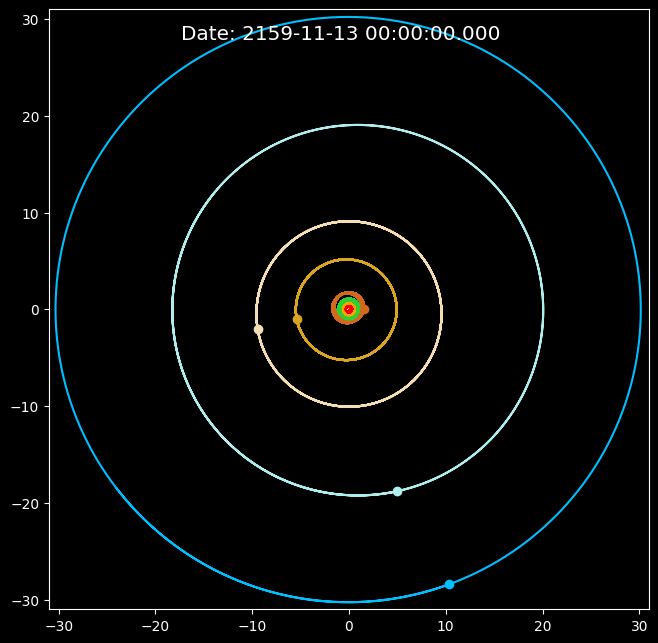

In [ ]:
# adjustable parameters
timeframe = (int)(200 * 365 / dt) # number of dts
dt = 10
start_time_yyyy_mm_dd = "1960-01-01"

# converted parameters
start_time_jd = Time(start_time_yyyy_mm_dd).jd
time = start_time_jd

# create plot
plt.style.use('dark_background')
fig = plt.figure(figsize=[6, 6])
ax = plt.axes([0., 0., 1., 1.], xlim=(-31, 31), ylim=(-31, 31))
ax.scatter(0, 0, color='white') # this is the Sun
ax.set_aspect('equal')
timestamp = ax.text(.22, .95, 'Date: ', transform=ax.transAxes, fontsize='x-large')

# initialize planets
planetids = [199, 299, 399, 499, 599, 699, 799, 899]
colors = ['red', 'orange', 'limegreen', 'chocolate', 'goldenrod', 'wheat', 'paleturquoise', 'deepskyblue']
planets = []

for i in range(len(planetids)):
  planet_hor = Horizons(id=planetids[i], location='@sun', epochs=start_time_jd).vectors()
  planet = {
      'r'     : np.array([np.double(planet_hor[ri]) for ri in ['x', 'y', 'z']]),
      'v'     : np.array([np.double(planet_hor[vi]) for vi in ['vx', 'vy', 'vz']]),
      'point' : ax.scatter(planet['r'][0], planet['r'][1], color=colors[i]),
      'xs'    : [],
      'ys'    : [] # xs and ys to keep track of for trail
  }
  planets.append(planet)

# run the orbit and plot the xs and ys of each planet
Orbit(planets, time, dt, timestamp, timeframe)
for i in range(len(planets)):
    ax.plot(planets[i]['xs'], planets[i]['ys'], color=colors[i])
timestamp.set_text('Date: ' + Time(time + timeframe * dt, format='jd').iso)
plt.show()

Thank you for reading :) have a nice day!